# OSS multimodal embedding generation

In [1]:
!pip install -q opensearch-py requests-aws4auth
!pip install -U -q boto3 botocore awscli 

## Compute embedding for historical posts

In [3]:
import boto3 
import json

import base64
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from opensearchpy import OpenSearch, RequestsHttpConnection, AWSV4SignerAuth, helpers

In [4]:
boto3_session = boto3.session.Session()
region_name = boto3_session.region_name

s3 = boto3.client('s3')
aoss_client = boto3.client('opensearchserverless')
bedrock_runtime = boto3.client("bedrock-runtime")

multimodal_embed_model = 'amazon.titan-embed-image-v1'

In [5]:
def get_titan_multimodal_embedding(
    image_path:str=None,  # maximum 2048 x 2048 pixels
    description:str=None, # English only and max input tokens 128
    dimension:int=1024,   # 1,024 (default), 384, 256
    model_id:str=multimodal_embed_model
):
    payload_body = {"inputImage": None, "inputText": None}
    embedding_config = {
        "embeddingConfig": { 
             "outputEmbeddingLength": dimension
         }
    }
    
    # You can specify either text or image,  or both
    if image_path:
        with open(image_path, "rb") as image_file:
            input_image = base64.b64encode(image_file.read()).decode('utf8')
            
        payload_body["inputImage"] = input_image
            
    if description:
        payload_body["inputText"] = description

    assert payload_body, "please provide either an image and/or a text description"
    # print("\n".join(payload_body.keys()))

    if payload_body["inputImage"]==None and payload_body["inputText"]==None:
        return {"embedding": None}
    else:
        response = bedrock_runtime.invoke_model(
            body=json.dumps({**payload_body, **embedding_config}), 
            modelId=model_id,
            accept="application/json", 
            contentType="application/json"
        )

    return json.loads(response.get("body").read())

In [6]:
df = pd.read_csv("data_mapping.csv")

In [7]:
def get_embedding(row):
    image_path = row['local_path']
    description = row['text']
    embedding = get_titan_multimodal_embedding(image_path=image_path, dimension=1024, description = description)["embedding"]
    return embedding

In [8]:
%%time 
df['embedding'] = df.apply(get_embedding, axis=1)

CPU times: user 1.86 s, sys: 497 ms, total: 2.36 s
Wall time: 38.4 s


In [9]:
df.head()

,text,file_name,local_path,embedding
0,Embrace the essence of sophistication with thi...,perfume-13.png,./images/perfume/perfume-13.png,"[-0.03397599, -0.012292411, -0.012447333, -0.0..."
1,Elevate your style with this captivating fragr...,perfume-4.png,./images/perfume/perfume-4.png,"[-0.02803378, 0.002037771, -0.020004997, -0.01..."
2,Indulge in the timeless allure of a captivatin...,perfume-8.png,./images/perfume/perfume-8.png,"[-0.03904457, -0.02554696, -0.021194702, -0.03..."
3,Elevate your senses with this exquisite fragra...,perfume-6.png,./images/perfume/perfume-6.png,"[-0.03851965, 0.00061492715, -0.011661577, -0...."
4,Embrace the essence of elegance with this capt...,perfume-11.png,./images/perfume/perfume-11.png,"[-0.03704527, -0.035198316, -0.015494727, -0.0..."


# Ingest embeddings to OSS 

In [10]:
import random
from utility import *
# The utility provides functions to create Bedrock execution roles and OSS policies.

In [11]:
suffix = boto3.client('sts').get_caller_identity().get('Account')
vector_store_name = f'social-media-{suffix}'

bucket_name = "blog-post-data"

bedrock_kb_execution_role = create_bedrock_execution_role(bucket_name=bucket_name)
bedrock_kb_execution_role_arn = bedrock_kb_execution_role['Role']['Arn']
bedrock_kb_execution_role_arn

## Create Collection
encryption_policy, network_policy, access_policy = create_policies_in_oss(vector_store_name=vector_store_name,
                       aoss_client=aoss_client,
                       bedrock_kb_execution_role_arn=bedrock_kb_execution_role_arn)

collection = aoss_client.create_collection(name=vector_store_name,type='VECTORSEARCH', standbyReplicas='DISABLED')
collection_id = collection['createCollectionDetail']['id']

In [12]:
host = collection_id + '.' + region_name + '.aoss.amazonaws.com'

In [14]:
# wait for collection creation
# This can take couple of minutes to finish
response = aoss_client.batch_get_collection(names=[vector_store_name])
# Periodically check collection status
while (response['collectionDetails'][0]['status']) == 'CREATING':
    print('Creating collection...')
    interactive_sleep(30)
    response = aoss_client.batch_get_collection(names=[vector_store_name])
print('\nCollection successfully created:')

Creating collection...
Creating collection...........
Creating collection...........
Creating collection...........
Creating collection...........
Creating collection...........
Creating collection...........
Creating collection...........
Creating collection...........
..............................
Collection successfully created:


In [24]:
response = aoss_client.batch_get_collection(names=[vector_store_name])
response['collectionDetails'][0]['id']

'iwpomel2rjeseo3jkdfl'

In [15]:
## Set up opensearch serverless index
service = 'aoss'
credentials = boto3.Session().get_credentials()
awsauth = AWSV4SignerAuth(credentials, region_name, service)

# Build the OpenSearch client
oss_client = OpenSearch(
    hosts=[{'host': host, 'port': 443}],
    http_auth=awsauth,
    use_ssl=True,
    verify_certs=True,
    connection_class=RequestsHttpConnection,
    timeout=300
)

## Create index

In [16]:
def create_index_titan(index_name, emb_dim):
    
    index_body = {
           "settings": {
              "index.knn": "true"
           },
           "mappings": {
              "properties": {
                 "image_vector": {
                    "type": "knn_vector",
                    "dimension": emb_dim # Embedding size for Amanon Titan Multimodal Embedding G1 model, it is 1,024 (default), 384, 256
                 },
                 "file_name": {"type": "text"},
                 "post_text": {"type": "text"}
              }
           }
        }
    try:
        response = oss_client.indices.create(index_name, body=index_body)
        print(f"response received for the create index -> {response}")
    except Exception as e:
        print(f"error in creating index={index_name}, exception={e}")
    
        
index_name = f"social-media-blog-img-text"        
create_index_titan(index_name, 1024)

response received for the create index -> {'acknowledged': True, 'shards_acknowledged': True, 'index': 'social-media-blog-img-text'}


In [17]:
%%time
## ingest image embeddings

import tqdm.notebook as tq

for idx, record in tq.tqdm(df.iterrows(), total=len(df)):
    document = {
                'image_vector': df['embedding'][idx],
                "file_name":   df['file_name'][idx],
                "post_text":   df['text'][idx],
                }
    response = oss_client.index(
    index = index_name,
    body = document
    )

  0%|          | 0/77 [00:00<?, ?it/s]

CPU times: user 488 ms, sys: 22.4 ms, total: 511 ms
Wall time: 34.3 s


## Test the multimodal search

In [18]:
def get_image(file_name, df):

    item_idx = df.query(f"file_name == '{file_name}'").index[0]
    img_loc =  df.iloc[item_idx].local_path


    img = Image.open(img_loc)
    return img

def find_similar_items_from_query(query_prompt: str, k: int, num_results: int, index_name: str, dataset, open_search_client ) -> []:
    """
    Main semantic search capability using knn on input query prompt.
    Args:
        k: number of top-k similar vectors to retrieve from OpenSearch index
        num_results: number of the top-k similar vectors to retrieve
        index_name: index name in OpenSearch
    """
    query_emb = get_titan_multimodal_embedding(description=query_prompt, dimension=1024)["embedding"]


    
    body = {
        "size": num_results,
        "_source": {
            "exclude": ["image_vector"],
        },
        "query": {
            "knn": {
                "image_vector": {
                    "vector": query_emb,
                    "k": k,
                }
            }
        },
    }
    
    res = open_search_client.search(index=index_name, body=body)
    images = []

    
    for hit in res["hits"]["hits"]:
        id_ = hit["_id"]
        file_name = hit["_source"]["file_name"]
        post_text = hit["_source"]["post_text"]
        image = get_image(file_name = file_name, df = df)
        
        image.name_and_score = f'{hit["_score"]}:{hit["_source"]["file_name"]}'
        images.append(image)
        
    return images

In [19]:
def display_images(
    images: [Image], 
    columns=2, width=20, height=8, max_images=15, 
    label_wrap_length=50, label_font_size=8):
 
    if not images:
        print("No images to display.")
        return 
 
    if len(images) > max_images:
        print(f"Showing {max_images} images of {len(images)}:")
        images=images[0:max_images]
 
    height = max(height, int(len(images)/columns) * height)
    plt.figure(figsize=(width, height))
    for i, image in enumerate(images):
 
        plt.subplot(int(len(images) / columns + 1), columns, i + 1)
        plt.imshow(image)
 
        if hasattr(image, 'name_and_score'):
            plt.title(image.name_and_score, fontsize=label_font_size); 
          

**Note**: On the next cell, if you see no `No images to display`, you may need to wait a few minutes for OpenSearch to finish the ingestion.

Please run the following cell again.

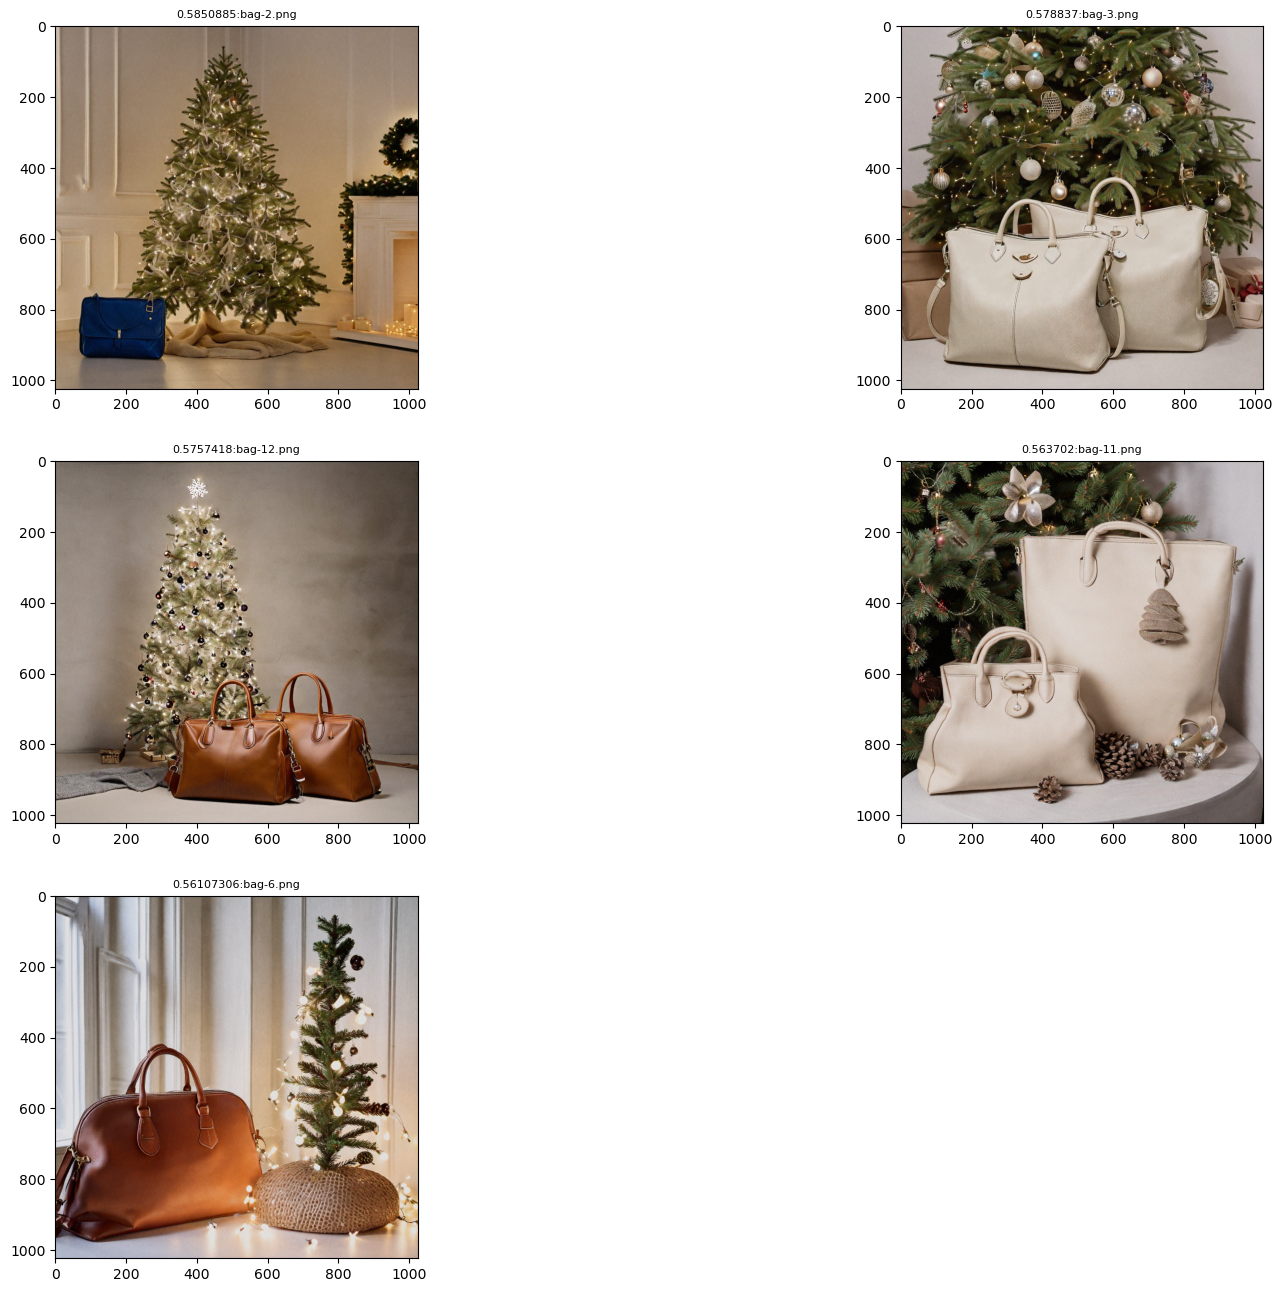

In [21]:
query_prompt = "christmas tree, holiday, bags"

similar_items = find_similar_items_from_query(query_prompt = query_prompt, k=3, num_results=5, index_name=index_name, dataset = df, 
                                   open_search_client = oss_client)

display_images(similar_items)